# Previous Work

For this notebook I used the [FER-2013](https://www.kaggle.com/msambare/fer2013) dataset, wich can be found on kaggle.

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

The final test accuracy achieved by the model proposed in this notebook is <font color='green'>0.6436</font>, making use of a model with <font color='green'>426,758</font> parameters. 

The best score that can be found on [kaggel](https://www.kaggle.com/anantgupt/facial-emotion-recogination-91-accuracy-train-set) for this challenge at this date (19-12-2020) is <font color='orange'>0.6656</font> accuracy for the test set, making use of a model with <font color='orange'>32,116,103</font> parameters that has a great campacity and can easily overfit on the training data

That is almost 100 times more parameters for ~2% increase in performance.


The performance of the model proposed in this notebook could be increased by the use of deeper arhitectures, pretrained models and hyperparameter tuning, but the idea of this notebook is not to directly build the best model or achive the best performance on the [FER-2013](https://www.kaggle.com/msambare/fer2013) dataset. Rather I would like to show an end to end process that goes from a quick Exploratory Data Analysis (EDA) of the dataset, to the development and evaluation of a light and **fast** model, that could facilitate it's incorporation into other apps and the possibility of processing the data on "real time", as well as the implementation of Grad-CAM an algorith for ML explainability that help us interpretate what the model is actually using for a particular decision. 

I am also a huge fan of Lean development, so I think its better to build something that can be easily tested and validated rather than directly spending a lot of time an effort building something that nobody will use

# Importing some modules and uploading the data

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%%capture
#Dta can be downloaded from https://www.kaggle.com/msambare/fer2013
!unzip /content/drive/MyDrive/FER-2013/archive.zip

In [3]:
import os
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
from collections import Counter
import numpy as np

# EDA

In [4]:
# Search and extract the image files and their labels
# Search on the training folder
X_train, y_train = [], []
for root, dirs, files in os.walk("/content/train"):
  for file_name in files:
      X_train.append(os.path.join(root, file_name))
      y_train.append(root.split("/")[-1])

# Search on the testing folder
X_test, y_test = [], []
for root, dirs, files in os.walk("/content/test"):
  for file_name in files:
      X_test.append(os.path.join(root, file_name))
      y_test.append(root.split("/")[-1])

print(len(X_train), "training images")
print(len(X_test), "testing images")

28709 training images
7178 testing images


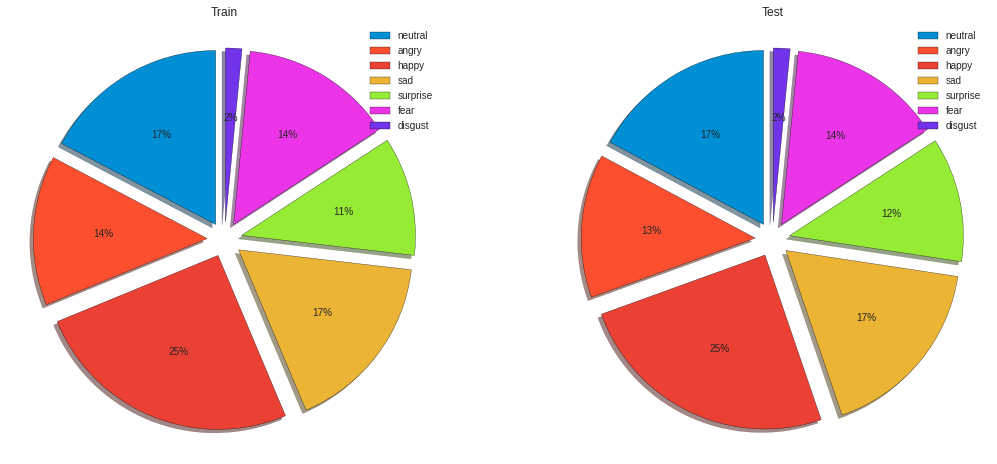

In [5]:
plt.style.use('seaborn')
# Count training items
train_counter = Counter(y_train)
train_count = [train_counter[key] for key in train_counter.keys()]

# Count testing items
test_counter = Counter(y_test)
test_count = [test_counter[key] for key in test_counter.keys()]

# Select colours for each label
colors = ['#008fd5', '#fc4f30', '#eb4034', '#ebb434', '#96eb34', '#eb34e8', '#7134eb']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
explode2 = (0.2, 0)

f = plt.gcf()
f.set_size_inches(18,8)
plt.subplot(1,2,1)

# Pie plot of the percentage of training items
plt.pie(train_count, startangle=90, colors=colors, 
        wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', 
        explode = explode, shadow=True)
plt.title("Train")
plt.legend(loc='best', labels=train_counter.keys(), fontsize='medium')

# Pie plot of the percentage of testing items
plt.subplot(1,2,2)
plt.pie(test_count, startangle=90, colors=colors, 
        wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', 
        explode = explode, shadow=True)
plt.title("Test")
plt.legend(loc='best', labels=test_counter.keys(), fontsize='medium')

plt.show()

In [6]:
# I decided to exclude the "disgust" class because of the lack of examples 
X_train, y_train = [], []
for root, dirs, files in os.walk("/content/train"):
  for file_name in files:
      mood = root.split("/")[-1]
      if mood != "disgust":
        X_train.append(os.path.join(root, file_name))
        y_train.append(root.split("/")[-1])

X_test, y_test = [], []
for root, dirs, files in os.walk("/content/test"):
  for file_name in files:
      mood = root.split("/")[-1]
      if mood != "disgust":
        X_test.append(os.path.join(root, file_name))
        y_test.append(root.split("/")[-1])

print(len(X_train), "training images")
print(len(X_test), "testing images")

28273 training images
7067 testing images


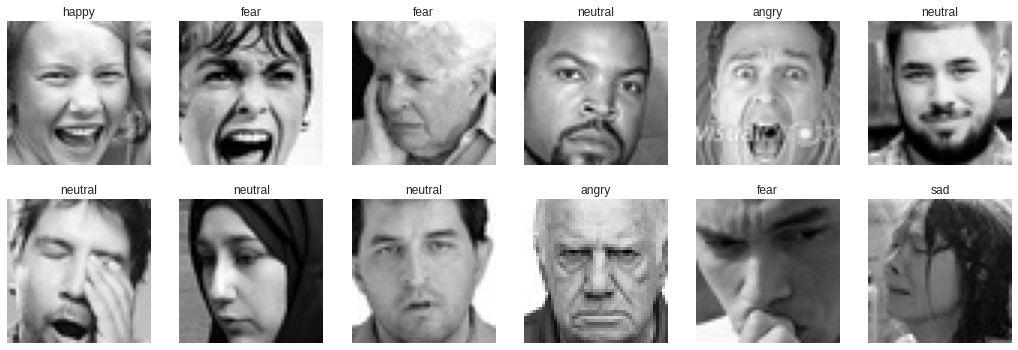

In [10]:
f, axs = plt.subplots(2,6, figsize=(18,6))
L = np.round(np.random.random(12) * len(X_train)).astype('int16')
for i, ax in enumerate(axs.flat):
    A = io.imread(X_train[L[i]])
    ax.imshow(A, cmap='gray')
    ax.set_title(y_train[L[i]])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# Data Pipeline

In [ ]:

#@title Data Generator and data augmentation
import sys
import imgaug.augmenters as iaa
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
     'Generates data for Keras'
     def __init__(self,img_path, label_path, batch_size=16, shuffle=True, augment = True, IMG_H=48, IMG_W=48):
         self.img_path = img_path
         self.label_path = label_path
         self.batch_size = batch_size
         self.shuffle = shuffle
         self.IMG_H = IMG_H
         self.IMG_W = IMG_W
         self.label_encoding = label_encoding = {'angry': 0, 'sad': 1, 'neutral': 2, 'surprise': 3, 'fear': 4, 'happy': 5}

         self.N_img = len(self.img_path)
         self.batches = self.N_img//self.batch_size 
         self.augment = augment
         self.on_epoch_end()
          
     def __len__(self):
        'Denotes the number of batches per epoch'
        return self.batches 
          
     def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.N_img)
        self.n = 0

        if self.shuffle:  
          np.random.shuffle(self.indexes)

     def __next__(self):
         # Get one batch of data
         data = self.__getitem__()
         # Batch index
         self.n += 1
         # If we have processed the entire dataset then
         if self.n == self.batches:
             self.on_epoch_end()
        
         return data

     def __getitem__(self):
        'Generate one batch of data'
        # selects indices of data for next batch
        batch_indexes = self.indexes[self.n * self.batch_size : (self.n + 1) * self.batch_size]

        # select data and load images
        images = np.zeros((len(batch_indexes), self.IMG_H, self.IMG_W),dtype='uint8')
        labels = np.zeros(len(batch_indexes))
        for n, k in enumerate(batch_indexes):
          img = io.imread(self.img_path[k])
          #img_rsz = cv2.resize(img, (self.IMG_H, self.IMG_W), cv2.INTER_CUBIC)
          images[n] = img
          labels[n] = self.label_encoding[self.label_path[k]]

        images = self.preproces(images)

        return images, labels
      
     def preproces(self, images):
         'Ddata transformations'
         if self.augment == True:
           # Initialize data augmentation process
           self.augmentor()
           images = self.seq1(images=images)

         # Rescale images
         images = (images.astype('float32'))/127.5
         images -= 1
         return images[:,:,:,np.newaxis]

     def augmentor(self):
          'Apply data augmentation'
          self.seq1 = iaa.Sequential([
            # Horizontal Flip                                      
            iaa.Fliplr(0.5),
            # Contrast
            iaa.LinearContrast((0.85, 1.15)),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0),
            # Brightness
            iaa.Multiply((0.85, 1.15), per_channel=0),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
                translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)},
                rotate=(-7, 7),
                shear=(-2, 2)
            )
            ], random_order=True)

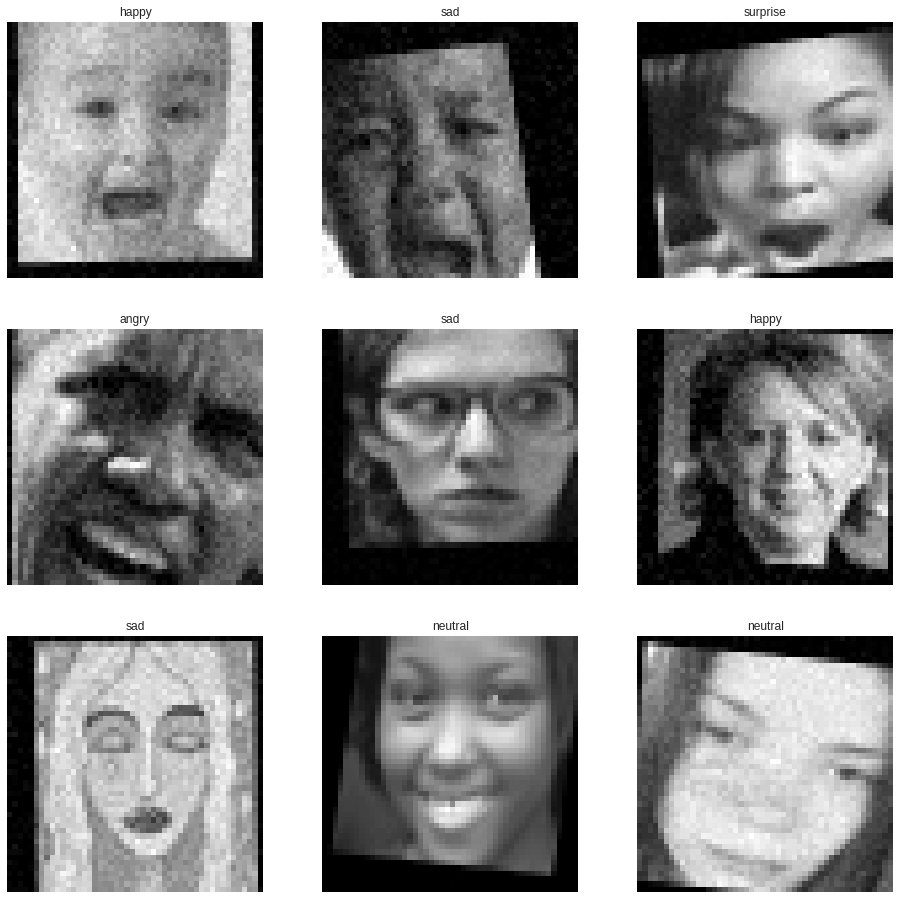

In [ ]:
train_generator = DataGenerator(img_path = X_train,
                                label_path = y_train,
                                batch_size = 16,
                                augment = True)
x, y = next(train_generator)
label_encoding = {'angry': 0, 'sad': 1, 'neutral': 2, 'surprise': 3, 'fear': 4, 'happy': 5}
label_decoding = dict((v,k) for k,v in label_encoding.items())
f, axs = plt.subplots(3,3, figsize=(16,16))
for i, ax in enumerate(axs.flat):
    ax.imshow(x[i,:,:,0], cmap='gray')
    ax.set_title(label_decoding[y[i]])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

# CNN Model

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
# I selected a simple model just as a first approximation and in order to save some time 
# Note : Lighter models can be faster, easier to deploy on other devices such as movil apps and 
# be of help for "real-time" video processing.
model = keras.Sequential(
    [
        keras.Input(shape=(48,48,1)),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), padding='same'),
        layers.BatchNormalization(axis=-1),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(np.unique(y_train)), activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
activation_4 (Activation)    (None, 24, 24, 128)       0

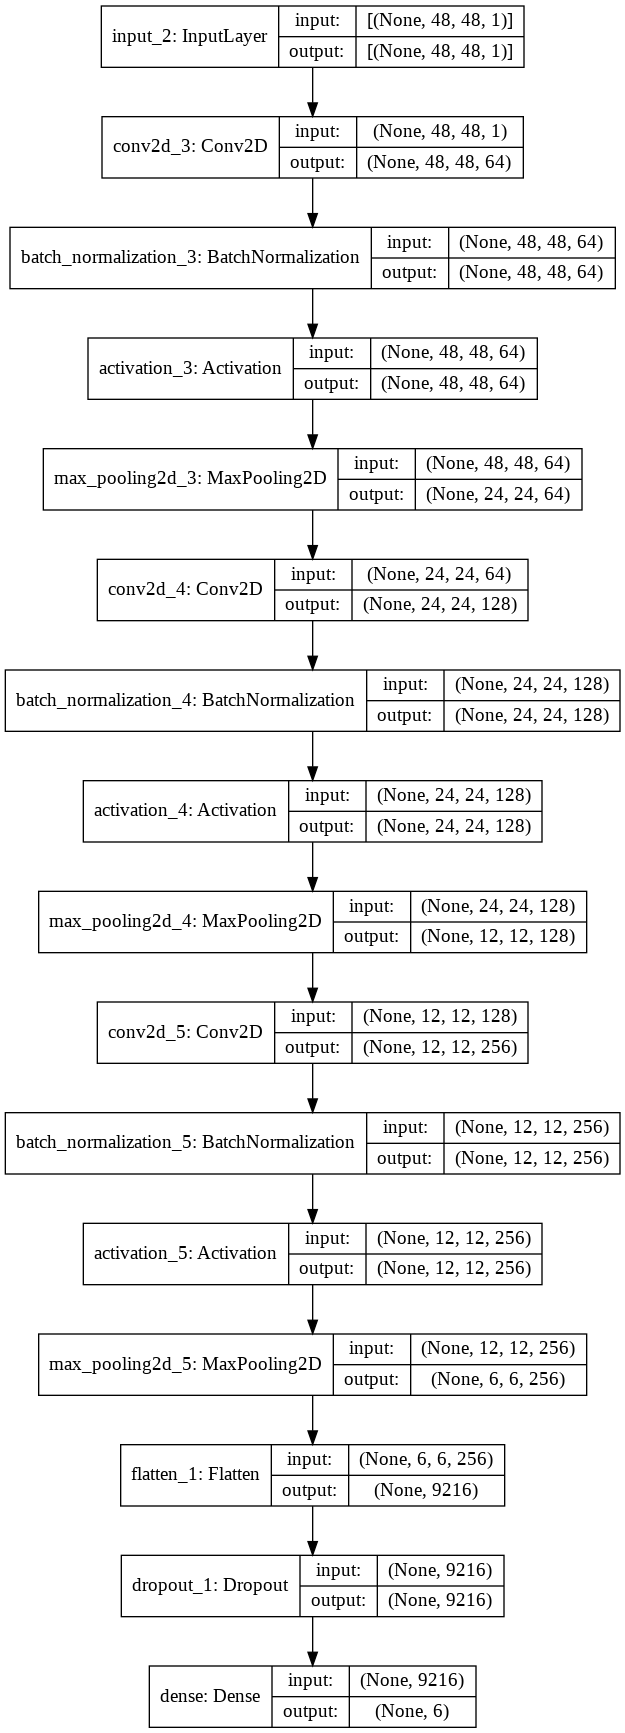

In [4]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 64
epochs = 100
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['sparse_categorical_accuracy'])

In [ ]:
train_generator = DataGenerator(img_path = X_train,
                                label_path = y_train,
                                batch_size = 64,
                                augment = True)
val_generator = DataGenerator(img_path = X_test,
                                label_path = y_test,
                                batch_size = 64,
                                augment = False)
def my_train_generator():
  while True:
    yield next(train_generator)

def my_val_generator():
  while True:
    yield next(val_generator)

In [ ]:
from sklearn.utils import compute_class_weight
k_train = compute_class_weight('balanced', np.unique(y_train), y_train)
wt = dict(zip(np.unique(y_train), k_train))
print(wt)
label_encoding = {'angry': 0, 'sad': 5, 'neutral': 4, 'disgust': 1, 'surprise': 6, 'fear': 2, 'happy': 3}
class_weight = dict((v,wt[k]) for k,v in label_encoding.items())
print(class_weight)

{'angry': 1.0266046844269623, 'disgust': 9.406618610747051, 'fear': 1.0010460615781582, 'happy': 0.5684387684387684, 'neutral': 0.8260394187886635, 'sad': 0.8491274770777877, 'surprise': 1.293372978330405}
{0: 1.0266046844269623, 5: 0.8491274770777877, 4: 0.8260394187886635, 1: 9.406618610747051, 6: 1.293372978330405, 2: 1.0010460615781582, 3: 0.5684387684387684}


In [ ]:
import time
save_model_path = '/content/Mood_weights.h5'
cp = keras.callbacks.ModelCheckpoint(filepath=save_model_path, 
                                     monitor='val_loss', save_best_only=True, verbose=1)

start = time.time()

historial = model.fit_generator(my_train_generator(),
                      epochs=epochs,
                      steps_per_epoch= len(train_generator),
                      verbose=2, #class_weight=class_weight,
                      validation_data = my_val_generator(),
                      validation_steps = len(val_generator),
                      callbacks = [cp])
end = time.time()
tiempo = end - start
print('tiempo = ', tiempo/60, ' min')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
441/441 - 44s - loss: 2.2485 - sparse_categorical_accuracy: 0.2155 - val_loss: 1.8530 - val_sparse_categorical_accuracy: 0.2585

Epoch 00001: val_loss improved from inf to 1.85303, saving model to /content/Mood_weights.h5
Epoch 2/100
441/441 - 37s - loss: 1.8665 - sparse_categorical_accuracy: 0.2476 - val_loss: 1.6660 - val_sparse_categorical_accuracy: 0.3395

Epoch 00002: val_loss improved from 1.85303 to 1.66600, saving model to /content/Mood_weights.h5
Epoch 3/100
441/441 - 36s - loss: 1.7208 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.5529 - val_sparse_categorical_accuracy: 0.3831

Epoch 00003: val_loss improved from 1.66600 to 1.55294, saving model to /content/Mood_weights.h5
Epoch 4/100
441/441 - 36s - loss: 1.5938 - sparse_categorical_accuracy: 0.3559 - val_loss: 1.3919 - val_sparse_categorical_accuracy: 0.4489

Epoch 00004: val_loss improved from 1.55294 to 1.39187, saving model to /content/Mood_weights.h5
Epoch 5/100
441/441 - 36s - loss: 1.4962 - sparse_ca

In [ ]:
print(historial.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


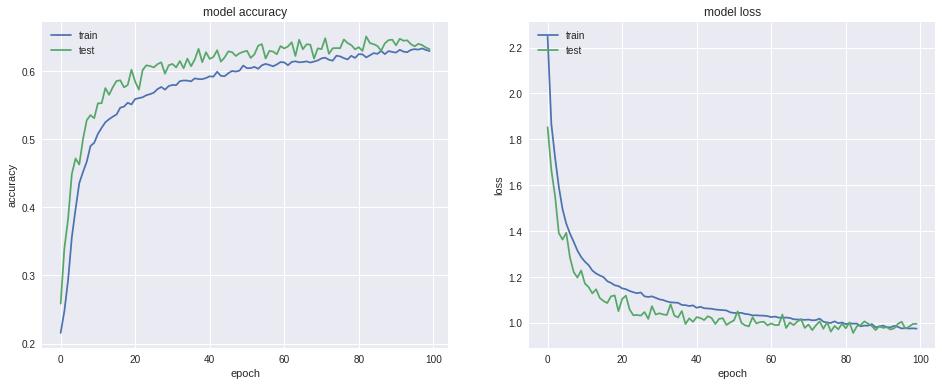

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16,6)
plt.subplot(1,2,1)
plt.plot(historial.history['sparse_categorical_accuracy'])
plt.plot(historial.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Note: Model can be trainer for more epochs and performance is likely to increase
#model.load_weights("/content/Mood_weights.h5")
model.load_weights("/content/drive/MyDrive/FER-2013/Mood_weights (1).h5")

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i,:,:,0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap='gray')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("pred: {} {:2.0f}% (true: {})".format(label_decoding[predicted_label],
                                100*np.max(predictions_array),
                                label_decoding[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  #
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(6), ['angry', 'sad', 'neutral', 'surprise', 'fear', 'happy'], rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(6), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('blue')

In [ ]:
val_generator.on_epoch_end() # Restart data generator
label_encoding = {'angry': 0, 'sad': 1, 'neutral': 2, 'surprise': 3, 'fear': 4, 'happy': 5}
label_decoding = dict((v,k) for k,v in label_encoding.items())

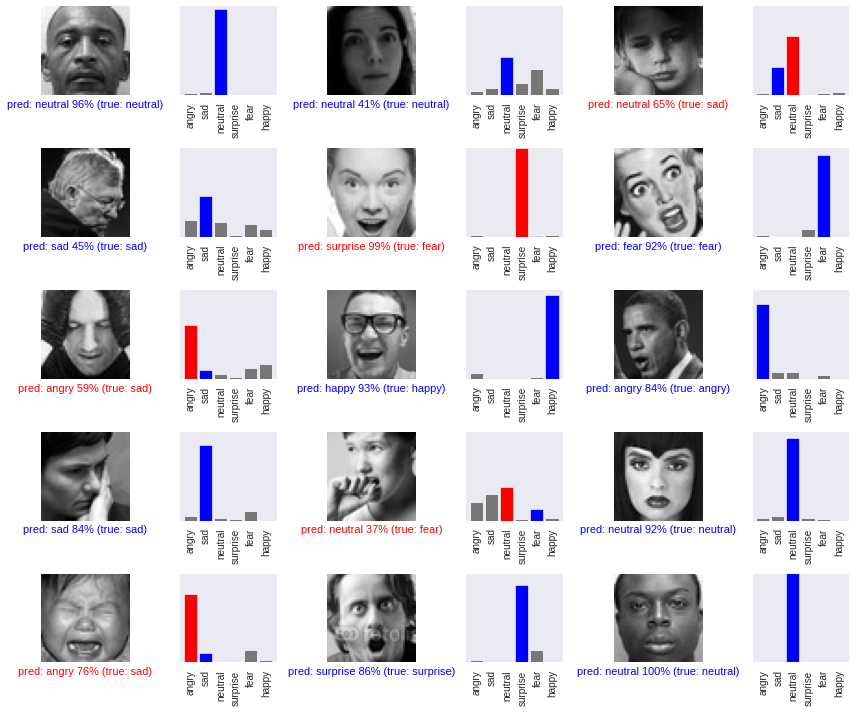

In [ ]:
X_test, y_test = next(val_generator)
y_pred = model.predict(X_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, y_pred[i],  y_test)
plt.tight_layout()
plt.show()

As you can see, even for a person, **predicting the correct emotion is highly subjective**, some expressions look very much alike and can be easily confused, even in the ground truth, there are some faces that could be interpreted in a different way and hence be associated with a different class by different people, based on their own judgment

#Save and download the model

In [ ]:
from google.colab import files

In [ ]:
model_json = model.to_json()
with open("Moods.json", "w") as json_file:
    json_file.write(model_json)
files.download("Moods.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/Mood_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model metrics

In [ ]:
#@title plot_confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
X_test, y_test = [], []
for root, dirs, files in os.walk("/content/test"):
  for file_name in files:
      mood = root.split("/")[-1]
      if mood != "disgust":
        X_test.append(os.path.join(root, file_name))
        y_test.append(root.split("/")[-1])

print(len(X_test), "testing images")

7067 testing images


In [ ]:
# Create a data generator instance
train_generator = DataGenerator(img_path = X_test,
                                label_path = y_test,
                                batch_size = 7067,
                                augment = False)
# Extract a batch with all the testing image
X, y = next(train_generator)
y_pred = model.predict(X)
enc = np.argmax(y_pred, -1)
# Decode resulting predictions
label_pred = [label_decoding[i] for i in enc]
label_true = [label_decoding[i] for i in y]

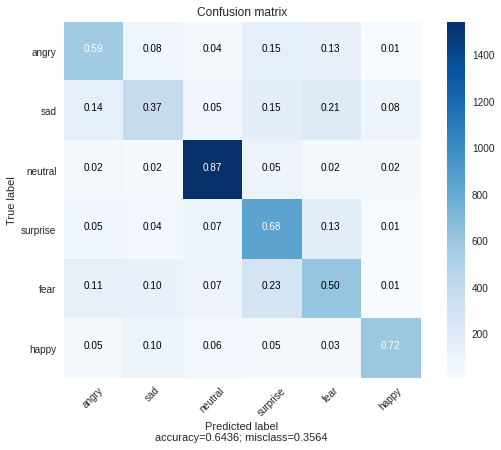

In [ ]:
# Genearte a confussion matrix to compare model performance on each class
plot_confusion_matrix(confusion_matrix(label_true, label_pred), ['angry', 'sad', 'neutral', 'surprise', 'fear', 'happy'])

As stated above some classes (e.g fear and surprise) look very much alike and are easily misclassified by the model, the same goes for sadness and fear 